Set up Google Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Install Required Package

In [2]:
# # Install require package
# ! pip install -U git+https://github.com/qubvel/segmentation_models.pytorch
# # ! pip install albumentations
# # ! pip install opencv
# ! apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python #install openCV
# ! pip install -U segmentation-models-pytorch albumentations --user  # install albumentation
# ! pip install -U segmentation-models-pytorch
# ! pip install icecream
# ! pip install imgaug

Import package

In [3]:
# import required module
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' #select multi GPU's
import numpy as np
import matplotlib.pyplot as plt
import cv2  #import Image read package
import albumentations as albu  # import required packages for data augmentation
from icecream import ic

# import modules for data extraction, augmentation, and preprocessing
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset


In [32]:
# Set directory of files
DATA_DIR = r'D:\Hassan\histology\data\annotated histology\augmented'
DATA_DIR1 = r'D:\Hassan\histology\data\annotated histology'

# /content/drive/MyDrive/Project_KCL/annotated histology/train/epidermis_mask

xTrainDir = os.path.join(DATA_DIR,'trainAugmented') #set Train Images dir
bodyTrainDir = os.path.join(DATA_DIR,'trainAugmentedmask')  #set Train body Label Images dir
# psoriasisTrainDir = os.path.join(DATA_DIR,'Psoriasis_Train_Label_Plaque')

xValidDir = os.path.join(DATA_DIR1,'valid\image')   #set Validation Images dir
bodyValidDir = os.path.join(DATA_DIR1,'valid\epidermis_mask')   #set Validation body Label Images dir 
# psoriasisValidDir = os.path.join(DATA_DIR,'Psoriasis_Valid_Label_Plaque')

xTestDir = os.path.join(DATA_DIR1,'test\image')  #set Test Images dir
bodyTestDir = os.path.join(DATA_DIR1,'test\epidermis_mask')  #set Test body Label Images dir
# psoriasisTestDir = os.path.join(DATA_DIR,'Psoriasis_Valid_Label_Plaque')


In [33]:
# Helper function for data visualization

def visualize(**images):
  n = len(images)
  plt.figure(figsize = (16,5)) 
  for i, (name, image) in enumerate(images.items()):
    plt.subplot(1, n, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(' '.join(name.split('_')).title())
    plt.imshow(image)
  plt.show()

In [34]:
#  Define class for data extraction, augmentation, and preprocessing

class Dataset(BaseDataset):

  CLASSES = ['body','background'] #Classes of Image mask
  # CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
  #            'tree', 'signsymbol', 'fence', 'car',
  #            'pedestrian', 'bicycclist', 'unlabelled']

  def __init__(
      self,
      imagesDir,
      annotationDir,
      classes = None,
      augmentation = None,
      preprocessing = None,
  ):
    self.ids = os.listdir(imagesDir)
    self.imagesFps = [os.path.join(imagesDir,imageID) for imageID in self.ids]  
    self.annotationsFps = [os.path.join(annotationDir,imageID) for imageID in self.ids]
    self.classValues = [self.CLASSES.index(cls.lower()) for cls in classes]
    self.augmentation = augmentation
    self.preprocessing = preprocessing

  def __getitem__(self,i):
    
    
    # read data
    image  = cv2.imread(self.imagesFps[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.stack(image)
    annotation = cv2.imread(self.annotationsFps[i],0) 

    #extract certain classes from annotation (Like- Body)
    annotations = [(annotation == v) for v in self.classValues]
    annotation = np.stack(annotations, axis = -1).astype('float')
    annotation = np.logical_not(annotation)
    annotation = np.array(annotation, dtype='int16')


    # apply augmentations
    if self.augmentation:
      sample = self.augmentation(image=image, mask=annotation)
      image, annotation = sample['image'], sample['mask']

    # Apply preprocessing
    if self.preprocessing:
      sample = self.preprocessing(image=image, mask=annotation)
      image, annotation = sample['image'], sample['mask']
    
    return image,annotation

  def __len__(self):
    return len(self.ids)


(2176, 3840, 3)
(2176, 3840, 1)


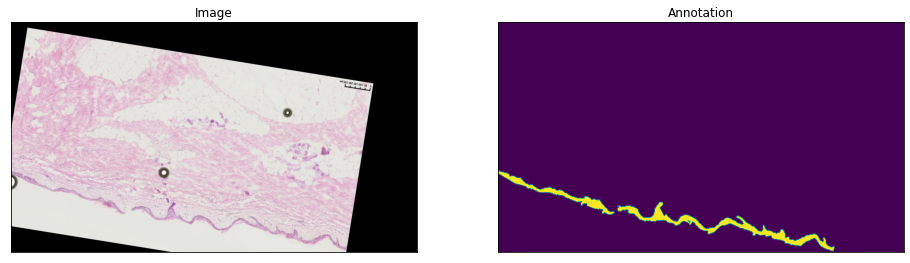

In [35]:
# Let's look at data we have

dataset = Dataset(xTrainDir,bodyTrainDir,classes=['Body']) # Check specific class to see the Image annotation

image, annotation = dataset[3] # get a sample
print(image.shape)
print(annotation.shape)

visualize(
    image = image,
    annotation = annotation.squeeze(),
)

In [101]:
# define function for data augmentation
def getTrainingAugmentation():
  trainTransform = [
#                     albu.HorizontalFlip(p=0.5), # horizontal flip 50%

#                     albu.ShiftScaleRotate(scale_limit = 0.5, rotate_limit = 0, shift_limit = 0.1, p = 1, border_mode = 0),

#                     albu.PadIfNeeded(min_height=640, min_width=960, always_apply=True, border_mode=0),
#                     albu.CropNonEmptyMaskIfExists(height=640, width=960, ignore_values=None, ignore_channels=None, always_apply=False, p=1.0),
                    
                      albu.Resize (height=640, width=960, interpolation=1, always_apply=True, p=1)
      
#                     albu.IAAAdditiveGaussianNoise(p=0.2),
#                     albu.IAAPerspective(p=0.5),
                      
                                        
#                     albu.OneOf(
#                         [
#                          albu.CLAHE(p=1),
#                          albu.RandomBrightness(p=1),
#                          albu.RandomGamma(p=1),
#                         ],
#                         p=0.9,
#                     ),

#                     albu.OneOf(
#                         [
#                          albu.IAASharpen(p=1),
#                          albu.Blur(blur_limit=3, p=1),
#                          albu.MotionBlur(blur_limit=3, p=1),
#                         ],
#                         p=0.9,
#                     ),

#                     albu.OneOf(
#                         [
#                          albu.RandomContrast(p=1),
#                          albu.HueSaturationValue(p=1),
#                         ],
#                         p=0.9,
#                     ),                    
  ]
  return albu.Compose(trainTransform)

def getValidationAugmentation():
  # add padding to make image shape divisible by 32
  testTransform = [
                   albu.PadIfNeeded(640,960) # change value 384,480 to 320,320
  ]
  return albu.Compose(testTransform)

def toTensor(x,**kwargs):
  return x.transpose(2, 0, 1).astype('float32')

def getPreprocessing(preprocessingFcn):
  # construct prprocessing transform

  _transform = [
                albu.Lambda(image = preprocessingFcn),
                albu.Lambda(image = toTensor, mask= toTensor),
  ]
  return albu.Compose(_transform)

(640, 960, 3)


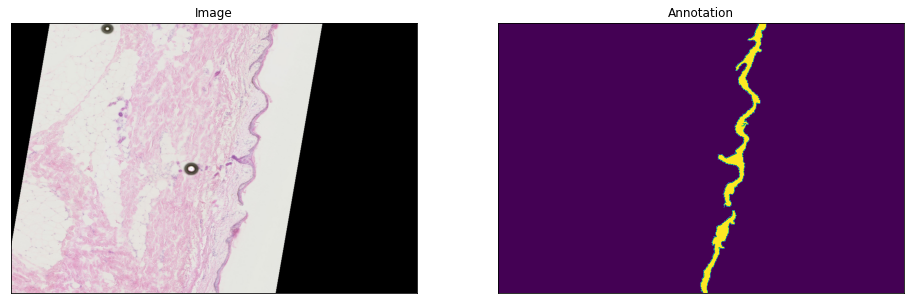

In [102]:
#  Visualize resulted augmented images and annotations
augmentedDataset = Dataset(
    xTrainDir,
    bodyTrainDir,
    augmentation = getTrainingAugmentation(),
    classes=['body'],
)

# same image with different random transforms
for i in range(1):
  image, annotation = augmentedDataset[i]
  print(image.shape)
  
  visualize(image=image, annotation =annotation.squeeze(-1))

In [43]:
# Import required package for create and train model
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [44]:
# create model
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['body']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = torch.device('cuda')

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

model = model.to(DEVICE)

preprocessingFcn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [45]:
# Data load

# Load Dataset for Train
trainDataset = Dataset(
    xTrainDir, 
    bodyTrainDir, 
    augmentation=getTrainingAugmentation(), 
    preprocessing=getPreprocessing(preprocessingFcn),
    classes=CLASSES,
)

# Load Dataset for Valid
validDataset = Dataset(
    xValidDir, 
    bodyValidDir, 
    augmentation=getTrainingAugmentation(), 
    preprocessing=getPreprocessing(preprocessingFcn),
    classes=CLASSES,
)

trainLoader = DataLoader(trainDataset, batch_size=1, shuffle=True, num_workers=0)
validLoader = DataLoader(validDataset, batch_size=1, shuffle=False, num_workers=0)

In [46]:
# Set train parameters
loss = smp.utils.losses.DiceLoss()

metrics = [
           smp.utils.metrics.IoU(threshold=0.5),
           smp.utils.metrics.Fscore(threshold=0.5),
           smp.utils.metrics.Accuracy(threshold=0.5),
           smp.utils.metrics.Recall(threshold=0.5),
           smp.utils.metrics.Precision(threshold=0.5),
]

optimizer = torch.optim.Adam([
                              dict(params = model.parameters(), lr =0.0001),
])


In [47]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch =smp.utils.train.ValidEpoch(
    model,loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [48]:
# train model for 40 epochs

max_score =0
for i in range(0,40):
  print('\nEpoch: {}'.format(i))
  train_logs = train_epoch.run(trainLoader)
  valid_logs = valid_epoch.run(validLoader)

  # do something (save model, change lr, etc.)
  if max_score < valid_logs['iou_score']:
    max_score = valid_logs['iou_score']
    torch.save(model,'./best_modelAugmented.pth')
    print('Model saved!')

  if i ==25:
    optimizer.param_groups[0]['lr'] = 1e-5
    print('Decrease decoder learning rate to 1e-5!')



Epoch: 0
train: 100%|█| 6370/6370 [45:53<00:00,  2.31it/s, dice_loss - 0.2703, iou_score - 0.6181, fscore - 0.7314, accuracy - 0
valid: 100%|█| 5/5 [00:02<00:00,  2.43it/s, dice_loss - 0.1913, iou_score - 0.6911, fscore - 0.8106, accuracy - 0.9821,
Model saved!

Epoch: 1
train: 100%|█| 6370/6370 [45:49<00:00,  2.32it/s, dice_loss - 0.2225, iou_score - 0.6766, fscore - 0.7784, accuracy - 0
valid: 100%|█| 5/5 [00:01<00:00,  2.51it/s, dice_loss - 0.2732, iou_score - 0.6701, fscore - 0.7271, accuracy - 0.9886,

Epoch: 2
train: 100%|█| 6370/6370 [45:47<00:00,  2.32it/s, dice_loss - 0.2146, iou_score - 0.6884, fscore - 0.7861, accuracy - 0
valid: 100%|█| 5/5 [00:02<00:00,  2.46it/s, dice_loss - 0.3567, iou_score - 0.557, fscore - 0.6442, accuracy - 0.9737, 

Epoch: 3
train: 100%|█| 6370/6370 [45:53<00:00,  2.31it/s, dice_loss - 0.2079, iou_score - 0.6974, fscore - 0.7935, accuracy - 0
valid: 100%|█| 5/5 [00:02<00:00,  2.44it/s, dice_loss - 0.3186, iou_score - 0.6187, fscore - 0.6819, accura

KeyboardInterrupt: 

In [75]:
bestModel = torch.load('./best_model2.pth')

In [108]:
# define function for data augmentation
def getTestAugmentation():
  trainTransform = [              
                      albu.Resize (height=640, width=960, interpolation=1, always_apply=True, p=1),                  
  ]
  return albu.Compose(trainTransform)


In [109]:

# create test dataset

testDataset = Dataset(
    xTestDir, 
    bodyTestDir, 
    augmentation=getTestAugmentation(), 
    preprocessing=getPreprocessing(preprocessingFcn),
    classes=CLASSES,
)

testDataloader = DataLoader(testDataset)

In [110]:

# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=bestModel,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(testDataloader)

valid: 100%|█| 5/5 [00:01<00:00,  3.33it/s, dice_loss - 0.23, iou_score - 0.6345, fscore - 0.7744, accuracy - 0.9934, r


In [111]:
# test dataset without transformations for image visualization
testDatasetVis = Dataset(
    xTestDir, bodyTestDir,
#     augmentation=getTrainingAugmentation(),  
#     preprocessing=getPreprocessing(preprocessingFcn),
    classes=CLASSES,
)

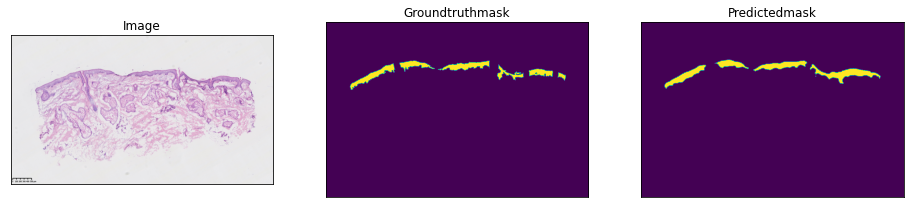

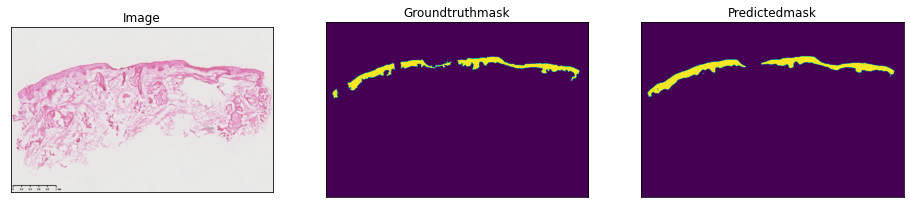

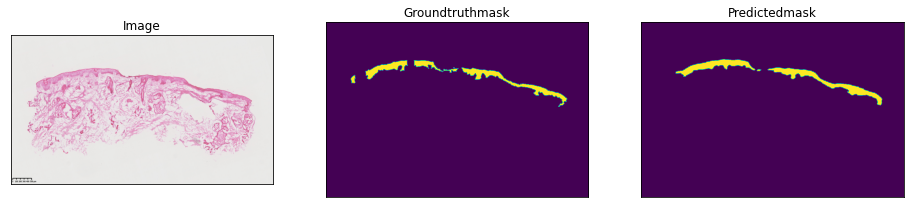

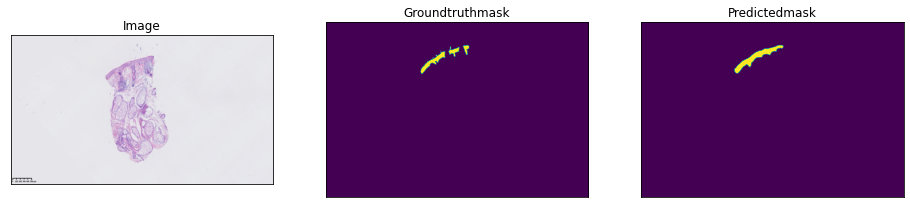

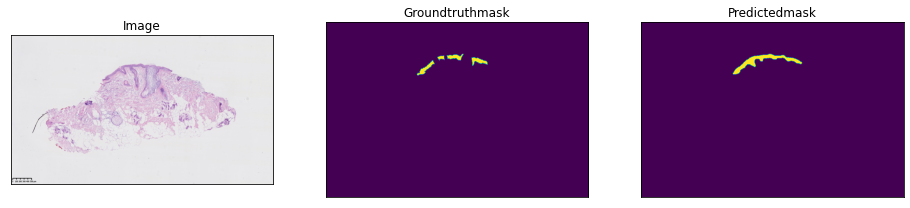

In [112]:
for i in range(5):
    n = np.random.choice(len(testDataset))
    n=i
    imageVis = testDatasetVis[n][0].astype('uint8')
    image, gtMask = testDataset[n]
    
    gtMask = gtMask.squeeze()
    
    xTensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    prMask = bestModel.predict(xTensor)
    prMask = (prMask.squeeze().cpu().numpy().round())
    image = image.astype('uint8')
    image = image.transpose(1,2,0)*255
    visualize(
        image= imageVis, 
        groundTruthMask=gtMask, 
        predictedMask=prMask
    )